#### IMPORTS, SETTINGS, DATA PREPARATION #####

In [1]:
import sys, os, warnings
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl 

os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

# Load and preprocess data
df = pd.read_csv("data/cheating_experiment_dataset.csv")

In [110]:
# Data preparation
df['cheating_behavior'] = df['cheating_behavior'].fillna(0)
df['integrity_group'] = pd.cut(
    df['cheating_behavior'],
    bins=[-0.001, 0.001, 0.999, 1.001],
    labels=['non_cheaters', 'partial_cheaters', 'full_cheaters']
)

df['condition'] = df['concept'].apply(
    lambda x: 'control' if pd.isna(x) else ('intervention' if x == 'intervention' else x)
)

# Order conditions
concept_order = [
    'control', 'intervention',
    'autonomy', 'competence', 'relatedness', 'self_concept',
    'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 
    'reference_group_identification', 'performance_accomplishments',
    'vicarious_experience', 'verbal_persuasion', 'emotional_arousal'
]

concept_display_names = {
    'control': 'Control',
    'intervention': 'Intervention',
    'autonomy': 'Autonomy (SDT)',
    'competence': 'Competence (SDT)',
    'relatedness': 'Relatedness (SDT)',
    'self_concept': 'Self Concept (SDT)',
    'cognitive_inconsistency': 'Cognitive Inconsistency (CDT)',
    'dissonance_arousal': 'Dissonance Arousal (CDT)',
    'dissonance_reduction': 'Dissonance Reduction (CDT)',
    'descriptive_norms': 'Descriptive Norms (SNT)',
    'injunctive_norms': 'Injunctive Norms (SNT)',
    'social_sanctions': 'Social Sanctions (SNT)',
    'reference_group_identification': 'Reference Group Identification (SNT)',
    'performance_accomplishments': 'Performance Accomplishments (SET)',
    'vicarious_experience': 'Vicarious Experience (SET)',
    'verbal_persuasion': 'Verbal Persuasion (SET)',
    'emotional_arousal': 'Emotional Arousal (SET)'
}

concept_display_names= {
    'control': 'Control',
    'intervention': 'Intervention',
    'autonomy': 'Autonomy (SDT)',
    'competence': 'Competence (SDT)',
    'relatedness': 'Relatedness (SDT)',
    'self_concept': 'Self Concept (SDT)',
    'cognitive_inconsistency': 'Cognitive Inconsistency (CDT)',
    'dissonance_arousal': 'Dissonance Arousal (CDT)',
    'dissonance_reduction': 'Dissonance Reduction (CDT)',
    'descriptive_norms': 'Descriptive Norms (SNT)',
    'injunctive_norms': 'Injunctive Norms (SNT)',
    'social_sanctions': 'Social Sanctions (SNT)',
    'reference_group_identification': 'Ref. Group Identity (SNT)',
    'performance_accomplishments': 'Perf. Accomplishments (SET)',
    'vicarious_experience': 'Vicarious Experience (SET)',
    'verbal_persuasion': 'Verbal Persuasion (SET)',
    'emotional_arousal': 'Emotional Arousal (SET)'
}

# Define mechanisms
mechanisms = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'injunctive_norms', 'descriptive_norms', 
    'social_sanctions', 'reference_group_identification', 
    'performance_accomplishments', 'vicarious_experience', 
    'verbal_persuasion', 'emotional_arousal', 'perceived_ability'
]

mechanism_display_names = {
    'autonomy_need_satisfaction': 'Autonomy Satisfaction',
    'autonomy_need_frustration': 'Autonomy Frustration',
    'competence_need_satisfaction': 'Competence Satisfaction',
    'competence_need_frustration': 'Competence Frustration',
    'relatedness_need_satisfaction': 'Relatedness Satisfaction',
    'relatedness_need_frustration': 'Relatedness Frustration',
    'cognitive_discomfort': 'Cognitive Discomfort',
    'moral_disengagement': 'Moral Disengagement',
    'injunctive_norms': 'Percv. Injunctive Norms',
    'descriptive_norms': 'Percv. Descriptive Norms',
    'social_sanctions': 'Percv. Social Sanctions',
    'reference_group_identification': 'Percv. Ref. Group Identity',
    'performance_accomplishments': 'Percv. Perf. Accomplishments',
    'vicarious_experience': 'Percv. Vicarious Experience',
    'verbal_persuasion': 'Percv. Verbal Persuasion',
    'emotional_arousal': 'Percv. Emotional Arousal',
    'perceived_ability': 'Percv. Ability'
}

# Define mechanism-to-theory mapping
mechanism_theory = {
    'autonomy_need_satisfaction': 'SDT',
    'autonomy_need_frustration': 'SDT',
    'competence_need_satisfaction': 'SDT',
    'competence_need_frustration': 'SDT',
    'relatedness_need_satisfaction': 'SDT',
    'relatedness_need_frustration': 'SDT',
    'cognitive_discomfort': 'CET',
    'moral_disengagement': 'CET',
    'injunctive_norms': 'SNT',
    'descriptive_norms': 'SNT',
    'social_sanctions': 'SNT',
    'reference_group_identification': 'SNT',
    'performance_accomplishments': 'SET',
    'vicarious_experience': 'SET',
    'verbal_persuasion': 'SET',
    'emotional_arousal': 'SET'
}

In [3]:
# Bootstrap function
def compute_integrity_distribution(data):
    result = data.groupby(['condition', 'integrity_group']).size().reset_index(name='n')
    totals = result.groupby('condition')['n'].sum().reset_index(name='total')
    result = result.merge(totals, on='condition')
    result['percent'] = (result['n'] / result['total']) * 100
    return result[['condition', 'integrity_group', 'percent']]

# Bootstrap sampling
n_bootstrap = 1000
boot_results = []
for _ in range(n_bootstrap):
    sample = df.sample(n=len(df), replace=True)
    boot_results.append(compute_integrity_distribution(sample))

boot_df = pd.concat(boot_results, ignore_index=True)

# Calculate confidence intervals
ci_df = boot_df.groupby(['condition', 'integrity_group'])['percent'].agg([
    ('mean', 'mean'),
    ('lower', lambda x: np.percentile(x, 2.5)),
    ('upper', lambda x: np.percentile(x, 97.5))
]).reset_index()

#### RQ1: 
#### **Do concept-based interventions reduce cheating behavior?** - ONLY SIGNIFICANT FOR FULL CHEATERS (~40% reduced relative to control) 
#### **Do effects vary by concepts?** - NO; all concepts reduce cheating behavior consistently

In [4]:
# =====================================================================
# Data preparation for RQ1 plots
# =====================================================================

# Combine intervention concepts
intervention_combined = df[df['condition'] != 'control'].copy()
intervention_combined['condition'] = 'intervention'
df_combined = pd.concat([df, intervention_combined], ignore_index=True)


boot_results_combined = []
for _ in range(n_bootstrap):
    sample = df_combined.sample(n=len(df_combined), replace=True)
    boot_results_combined.append(compute_integrity_distribution(sample))

boot_df_combined = pd.concat(boot_results_combined, ignore_index=True)
ci_df_combined = boot_df_combined.groupby(['condition', 'integrity_group'])['percent'].agg([
    ('mean', 'mean'),
    ('lower', lambda x: np.percentile(x, 2.5)),
    ('upper', lambda x: np.percentile(x, 97.5))
]).reset_index()


formatted_labels = [f'$\\bf{{{concept_display_names[c]}}}$' if c in ['control', 'intervention'] 
                    else concept_display_names[c] for c in concept_order]

sample_sizes = df_combined.groupby(['condition', 'integrity_group']).size().reset_index(name='n')
ci_df_combined = ci_df_combined.merge(sample_sizes, on=['condition', 'integrity_group'], how='left')


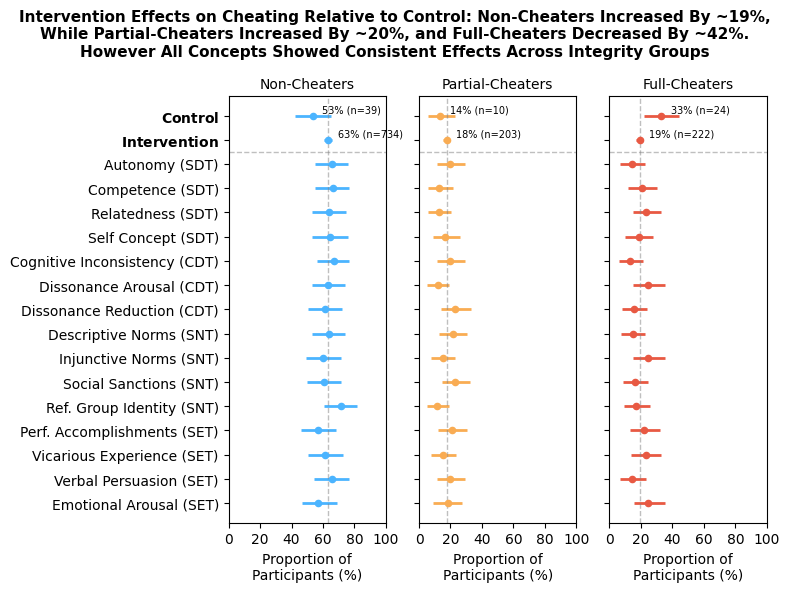


=== Cheating proportions used in plots (mean ± 95% CI) ===

Integrity group: NON_CHEATERS
                     Condition Mean (%) Lower CI Upper CI
                       control    53.48    42.30    64.91
                  intervention    63.33    60.80    65.94
                      autonomy    65.62    54.79    75.71
                    competence    66.24    54.88    76.82
                   relatedness    63.75    52.94    74.32
                  self_concept    64.66    52.94    75.56
       cognitive_inconsistency    66.92    56.34    76.47
            dissonance_arousal    63.32    53.22    74.16
          dissonance_reduction    61.42    50.57    71.80
             descriptive_norms    63.78    53.08    74.24
              injunctive_norms    60.24    49.42    71.25
              social_sanctions    60.41    50.00    71.22
reference_group_identification    71.47    60.56    81.58
   performance_accomplishments    57.00    45.83    68.36
          vicarious_experience    61.55

In [24]:
# =============================================================================
# RQ1 Plots: Integrity Distribution by Concept and Integrity Group
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(8, 6), sharey=True)
integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
colors = ["#4bb4ff", "#f9ac53", "#e85943"]
titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']

for idx, (ax, group, color, title) in enumerate(zip(axes, integrity_groups, colors, titles)):
    data = ci_df_combined[ci_df_combined['integrity_group'] == group]
    data = data.set_index('condition').reindex(concept_order).reset_index()
    
    y = np.arange(len(concept_order))
    ax.scatter(data['mean'], y, color=color, s=20, zorder=3)
    ax.hlines(y, data['lower'], data['upper'], color=color, linewidth=2, zorder=2)
    for _, row in data.iterrows():
        if row['condition'] in ['control', 'intervention']:
            ax.text(
                row['mean'] + 6, 
                y[list(data['condition']).index(row['condition'])] - 0.25,
                f"{row['mean']:.0f}% (n={row['n']})",  
                va='center', ha='left', fontsize=7, color='black'
            )
    
    ax.set_title(title, fontsize=10)
    ax.set_yticks(y)
    ax.set_yticklabels(formatted_labels, fontsize=10)
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.set_xlabel('Proportion of\nParticipants (%)', fontsize=10)
    # ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.axhline(y=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(x=data.loc[data['condition'] == 'intervention', 'mean'].values[0], 
           color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.invert_yaxis()
    
fig.suptitle(
    'Intervention Effects on Cheating Relative to Control: Non-Cheaters Increased By ~19%,\n'
    'While Partial-Cheaters Increased By ~20%, and Full-Cheaters Decreased By ~42%.\n'
    'However All Concepts Showed Consistent Effects Across Integrity Groups',
    fontsize=11, fontweight='bold', y=0.98
)


# fig.text(0.5, -0.02,
#             "SDT: Self-Determination Theory | CDT: Cognitive Dissonance Theory | "
#             "SNT: Social Norms Theory | SET: Self-Efficacy Theory",
#             ha='center', fontsize=9, style='italic', color='black', alpha=0.8)

plt.tight_layout()
# plt.savefig('integrity_distribution_by_concept.png', dpi=300, bbox_inches='tight')
plt.show()


# === (1) Print plotted values in concept_order ===
print("\n=== Cheating proportions used in plots (mean ± 95% CI) ===")

for group in integrity_groups:
    print(f"\nIntegrity group: {group.upper()}")
    subset = (
        ci_df_combined[ci_df_combined['integrity_group'] == group]
        .set_index('condition')
        .reindex(concept_order)
        .reset_index()
    )
    subset_print = subset[['condition', 'mean', 'lower', 'upper']].copy()
    subset_print.columns = ['Condition', 'Mean (%)', 'Lower CI', 'Upper CI']
    print(subset_print.to_string(index=False, formatters={
        'Mean (%)': '{:.2f}'.format,
        'Lower CI': '{:.2f}'.format,
        'Upper CI': '{:.2f}'.format
    }))

# === (2) Chi-square significance tests (Control vs Intervention) ===
from scipy.stats import chi2_contingency

print("\n=== Chi-square tests: Control vs Intervention for each integrity group ===")

for group in integrity_groups:
    # Count participants in this group by condition
    control_count = len(df[(df['condition'] == 'control') & (df['integrity_group'] == group)])
    intervention_count = len(df[(df['condition'] != 'control') & (df['integrity_group'] == group)])
    total_control = len(df[df['condition'] == 'control'])
    total_intervention = len(df[df['condition'] != 'control'])
    
    # 2x2 contingency: cheating group vs condition
    contingency = np.array([
        [control_count, total_control - control_count],
        [intervention_count, total_intervention - intervention_count]
    ])
    
    chi2, p, dof, exp = chi2_contingency(contingency)
    print(f"{group:>20s}: χ²={chi2:.3f}, p={p:.4f}")


#### RQ2a:
#### **Do concept-based interventions improve performance?** - NOT SIGNIFICANTLY; but slight improvement for non-cheaters
#### **Do effects vary by concepts?** - NOT TESTED BECAUSE NO SIGNIFICANT EFFECT
#### RQ2b:
#### **Do concept-based interventions improve experience?** - NOT SIGNIFICANTLY
#### **Do effects vary by concepts?** - NOT TESTED BECAUSE NO SIGNIFICANT EFFECT

In [25]:
# ---------------------------------------------------------------------
# Bootstrap mean and CI
# ---------------------------------------------------------------------
def bootstrap_mean_ci(data, metric, n_boot=1000):
    results = []
    for condition in ['control', 'intervention']:
        for integrity_group in ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']:
            subset = data[(data['condition'] == condition) & 
                         (data['integrity_group'] == integrity_group)][metric].dropna()
            if len(subset) > 0:
                boot_means = [subset.sample(n=len(subset), replace=True).mean() 
                              for _ in range(n_boot)]
                results.append({
                    'condition': condition,
                    'integrity_group': integrity_group,
                    'mean': np.mean(boot_means),
                    'lower': np.percentile(boot_means, 2.5),
                    'upper': np.percentile(boot_means, 97.5)
                })
    return pd.DataFrame(results)

In [26]:
# ---------------------------------------------------------------------
# Summary statistics and tests
# ---------------------------------------------------------------------
def summarize_and_test(df_all, df_combined, metric, integrity_groups, label):
    print(f"\n=== {label} Summary by Integrity Group and Condition ===")
    summary_rows = []
    for group in integrity_groups:
        plot_data = df_combined if group == 'all' else df_all[df_all['integrity_group'] == group]
        plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

        for condition in ['control', 'intervention']:
            condition_data = plot_data[plot_data['condition'] == condition][metric].dropna()
            summary_rows.append({
                'Integrity Group': group,
                'Condition': condition,
                'N': len(condition_data),
                'Mean': condition_data.mean(),
                'Median': condition_data.median(),
                'SD': condition_data.std()
            })

    summary_df = pd.DataFrame(summary_rows).set_index(['Integrity Group', 'Condition'])
    print(summary_df.to_string(formatters={'Mean': '{:.2f}'.format, 'Median': '{:.2f}'.format, 'SD': '{:.2f}'.format}))

    print(f"\n=== {label} Comparison: Control vs Intervention (Welch t-test) ===")
    for group in integrity_groups:
        plot_data = df_combined if group == 'all' else df_all[df_all['integrity_group'] == group]
        plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

        control_data = plot_data[plot_data['condition'] == 'control'][metric].dropna()
        intervention_data = plot_data[plot_data['condition'] == 'intervention'][metric].dropna()

        t_stat, p_val = ttest_ind(intervention_data, control_data, equal_var=False)
        u_stat, p_mw = mannwhitneyu(intervention_data, control_data, alternative='two-sided')
        pooled_sd = np.sqrt(((control_data.std() ** 2) + (intervention_data.std() ** 2)) / 2)
        d = (intervention_data.mean() - control_data.mean()) / pooled_sd

        print(f"\n{group.upper()}")
        print(f"  Welch t-test   : t={t_stat:.3f}, p={p_val:.4f}")
        print(f"  Mann-Whitney U : U={u_stat:.3f}, p={p_mw:.4f}")
        print(f"  Cohen's d      : {d:.3f}")

In [139]:
# ---------------------------------------------------------------------
# Violin + box plot visualization
# ---------------------------------------------------------------------
def plot_metric(df_all, df_combined, metric, label, y_label, y_lim, mean_ypos, n_ypos, subtitle):
    integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']
    titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters', 'All Combined']

    integrity_colors = {
        'non_cheaters': '#4bb4ff', 
        'partial_cheaters': '#f9ac53',
        'full_cheaters': '#e85943',
        'all': '#a0a0a0'
    }

    fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=True)
    for idx, (ax, group, title) in enumerate(zip(axes, integrity_groups, titles)):
        plot_data = df_combined if group == 'all' else df_all[df_all['integrity_group'] == group]
        plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

        control_data = plot_data[plot_data['condition'] == 'control'][metric].dropna()
        intervention_data = plot_data[plot_data['condition'] == 'intervention'][metric].dropna()

        # Violin + box
        parts = ax.violinplot([control_data, intervention_data], positions=[0, 1], widths=0.4,
                              showmeans=False, showmedians=False, showextrema=False)
        ax.boxplot([control_data, intervention_data], positions=[0, 1], widths=0.03,
                   patch_artist=True,
                   boxprops=dict(facecolor='black', color='black'),
                   medianprops=dict(color='white', linewidth=2),
                   whiskerprops=dict(color='black', linewidth=1),
                   capprops=dict(color='black', linewidth=1),
                   flierprops=dict(marker='o', markersize=3, markeredgecolor='black', alpha=0.7))

        # Color violins for control vs intervention
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(integrity_colors[group])
            pc.set_alpha(0.5 if i == 0 else 1.0)  # control lighter, intervention full
            pc.set_linewidth(1)

        # Annotate
        for pos, condition_data in enumerate([control_data, intervention_data]):
            ax.text(pos, n_ypos, f'n={len(condition_data)}', ha='center', va='top', fontsize=10)
            ax.text(pos, mean_ypos, f'M={condition_data.mean():.2f}', ha='center', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', linewidth=0.5, alpha=0.8))

        ax.set_title(title, fontsize=13, pad=15)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Control', 'Intervention'], fontsize=12)
        ax.set_ylim(*y_lim)
        if idx == 0:
            ax.set_ylabel(y_label, fontsize=12)
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.suptitle(subtitle, fontsize=14, fontweight='bold', y=0.93)
    plt.tight_layout(rect=[0, 0.1, 1, 0.90])
    plt.show()

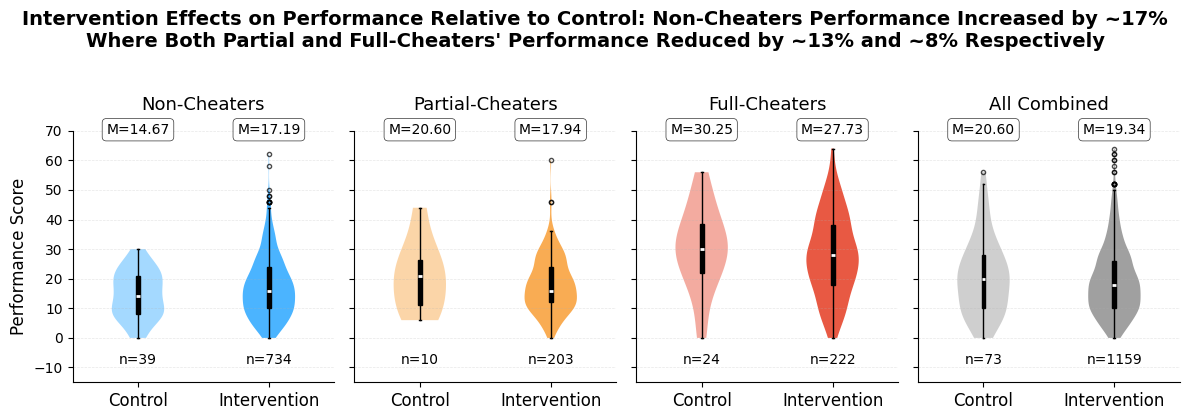


=== Performance Summary by Integrity Group and Condition ===
                                  N  Mean Median    SD
Integrity Group  Condition                            
non_cheaters     control         39 14.67  14.00  7.91
                 intervention   734 17.19  16.00 10.37
partial_cheaters control         10 20.60  21.00 11.85
                 intervention   203 17.94  16.00  9.18
full_cheaters    control         24 30.25  30.00 13.85
                 intervention   222 27.73  28.00 13.73
all              control         73 20.60  20.00 12.73
                 intervention  1159 19.34  18.00 11.64

=== Performance Comparison: Control vs Intervention (Welch t-test) ===

NON_CHEATERS
  Welch t-test   : t=1.909, p=0.0626
  Mann-Whitney U : U=15881.500, p=0.2476
  Cohen's d      : 0.274

PARTIAL_CHEATERS
  Welch t-test   : t=-0.699, p=0.5011
  Mann-Whitney U : U=897.000, p=0.5358
  Cohen's d      : -0.251

FULL_CHEATERS
  Welch t-test   : t=-0.848, p=0.4038
  Mann-Whitney U : U=2329

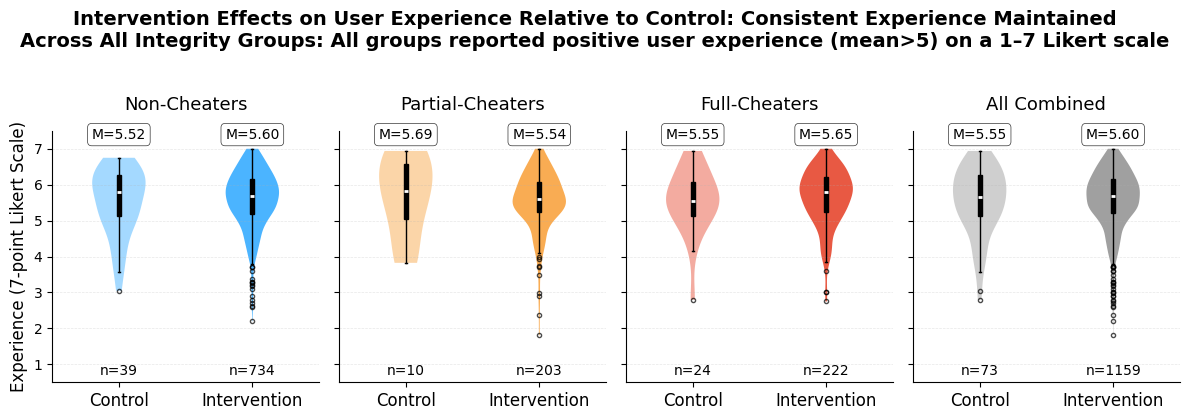


=== Experience Summary by Integrity Group and Condition ===
                                  N Mean Median   SD
Integrity Group  Condition                          
non_cheaters     control         39 5.52   5.81 0.93
                 intervention   734 5.60   5.70 0.80
partial_cheaters control         10 5.69   5.84 1.11
                 intervention   203 5.54   5.59 0.81
full_cheaters    control         24 5.55   5.55 0.90
                 intervention   222 5.65   5.79 0.79
all              control         73 5.55   5.65 0.93
                 intervention  1159 5.60   5.69 0.80

=== Experience Comparison: Control vs Intervention (Welch t-test) ===

NON_CHEATERS
  Welch t-test   : t=0.562, p=0.5773
  Mann-Whitney U : U=14639.500, p=0.8104
  Cohen's d      : 0.098

PARTIAL_CHEATERS
  Welch t-test   : t=-0.403, p=0.6957
  Mann-Whitney U : U=872.000, p=0.4539
  Cohen's d      : -0.147

FULL_CHEATERS
  Welch t-test   : t=0.522, p=0.6057
  Mann-Whitney U : U=2854.500, p=0.5661
  Cohen'

In [140]:
# =============================================================================
# RQ2 plots: Performance and Experience by Integrity Group and Condition
# =============================================================================

df_tmp = df_combined.copy()
df_tmp['integrity_group'] = 'all'
df_all = pd.concat([df_combined, df_tmp], ignore_index=True)
df_all['integrity_group'] = pd.Categorical(
    df_all['integrity_group'],
    categories=['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all'],
    ordered=True
)

# ---------------------------------------------------------------------
# Run for PERFORMANCE
# ---------------------------------------------------------------------
plot_metric(
    df_all, df_combined, 'performance', 'Performance',
    'Performance Score', (-15, 70), mean_ypos=68, n_ypos=-5,
    subtitle="Intervention Effects on Performance Relative to Control: Non-Cheaters Performance Increased by ~17%\n"
    "Where Both Partial and Full-Cheaters' Performance Reduced by ~13% and ~8% Respectively",
)
summarize_and_test(df_all, df_combined, 'performance', ['non_cheaters','partial_cheaters','full_cheaters','all'], 'Performance')

# ---------------------------------------------------------------------
# Run for EXPERIENCE
# ---------------------------------------------------------------------
plot_metric(
    df_all, df_combined, 'experience', 'Experience',
    'Experience (7-point Likert Scale)', (0.5, 7.5), mean_ypos=7.2, n_ypos=1,
    subtitle="Intervention Effects on User Experience Relative to Control: Consistent Experience Maintained\n"
    "Across All Integrity Groups: All groups reported positive user experience (mean>5) on a 1–7 Likert scale"
)
summarize_and_test(df_all, df_combined, 'experience', ['non_cheaters','partial_cheaters','full_cheaters','all'], 'Experience')

In [36]:
# Count scores in 40-50 range
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    data = df_all[df_all['integrity_group'] == group]
    
    for cond in ['control', 'intervention']:
        scores = data[data['condition'] == cond]['performance'].dropna()
        n_40_50 = ((scores >= 40) & (scores < 50)).sum()
        pct = n_40_50 / len(scores) * 100
        print(f"{group:20s} {cond:12s}: {n_40_50:3d}/{len(scores):3d} ({pct:4.1f}%) in 40-50 range")

non_cheaters         control     :   0/ 39 ( 0.0%) in 40-50 range
non_cheaters         intervention:  22/734 ( 3.0%) in 40-50 range
partial_cheaters     control     :   1/ 10 (10.0%) in 40-50 range
partial_cheaters     intervention:   2/203 ( 1.0%) in 40-50 range
full_cheaters        control     :   4/ 24 (16.7%) in 40-50 range
full_cheaters        intervention:  39/222 (17.6%) in 40-50 range


#### RQ3: What are the mechanisms through which concept-based interventions influence cheating behavior, performance, and experience across integrity groups? - EXPLORATORY

##### Next, to explore whether the effectiveness of concept-based interventions on cheating behavior, performance, and experience varies among different integrity groups, We have several options: 1) concepts predict cheating behavior, performance and experience for each integrity group; 2) concept to mechanism; and 3) then mechanisms to cheating behavior, performance and experience for each integrity group.
##### We have tested above Step 1; Step 2 and Step 3 will be done next.

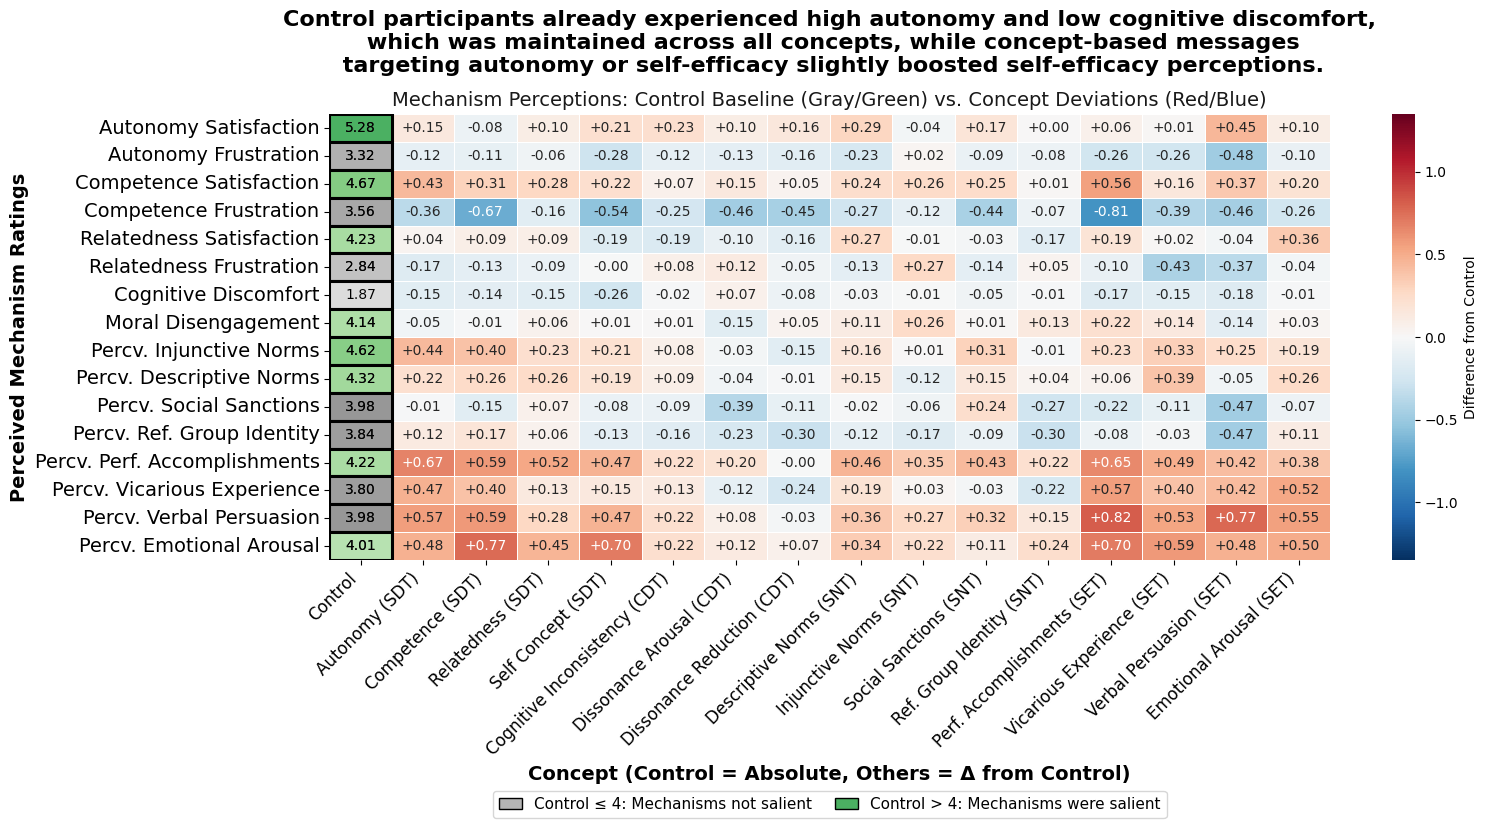

In [ ]:
#=============================================================================
# RQ3 Plot: Concept->Mechanism Perception Heatmap
#=============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# --- Data prep (same as your pipeline) ---
df_int = df[df['concept'].notna()].copy()
mechanisms_filtered = [m for m in mechanisms if m != 'perceived_ability']
concept_order_filtered = [c for c in concept_order if c != 'intervention']

concept_means = df_int.groupby('concept')[mechanisms_filtered].mean()
control_means = concept_means.loc['control']

concepts_without_control = [c for c in concept_order_filtered if c != 'control']
relative_data = concept_means.loc[concepts_without_control].subtract(control_means, axis=1)

plot_data = pd.concat([
    control_means.to_frame('control'),
    relative_data.T
], axis=1)

plot_columns = ['control'] + concepts_without_control
plot_data = plot_data[plot_columns]
plot_data.index = plot_data.index.map(mechanism_display_names)
plot_data.columns = plot_data.columns.map(concept_display_names)

# --- Annotations ---
annot_array = plot_data.copy()
annot_array.iloc[:, 0] = annot_array.iloc[:, 0].apply(lambda x: f"{x:.2f}")        # control absolute
annot_array.iloc[:, 1:] = annot_array.iloc[:, 1:].applymap(lambda x: f"{x:+.2f}")   # relative with sign

# --- Determine vmin/vmax from relative differences only ---
relative_values = plot_data.iloc[:, 1:].values.flatten()
vmin = np.floor(np.nanmin(relative_values) * 10) / 10
vmax = np.ceil(np.nanmax(relative_values) * 10) / 10

scale_factor = 1.5  # 1 = original, >1 = exaggerate differences
vmax_scaled = vmax * scale_factor
vmin_scaled = vmin * scale_factor

# --- Prepare a matrix for the heatmap (we'll use same numeric values for coloring of non-control columns)
# For the control column we will paste a numeric proxy in range [vmin, vmax]
# But we'll overlay custom colored rectangles for control to express threshold coloring.
control_vals = plot_data.iloc[:, 0].values
control_proxy = ((control_vals - 1) / 6) * (vmax - vmin) + vmin  # numeric proxy so heatmap cell sizes align

heatmap_data = plot_data.copy()
heatmap_data.iloc[:, 0] = control_proxy

# --- Create figure and main heatmap (the whole matrix) ---
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    annot=annot_array,
    fmt="",
    cmap='RdBu_r',
    center=0,
    vmin=vmin_scaled, vmax=vmax_scaled,
    cbar_kws={'label': 'Difference from Control'},
    linewidths=0.5,
    # linecolor='gray',
    ax=ax
)


# --- Overlay control column with threshold-based colors ---
# Define colormaps:
gray_cmap = plt.cm.Greys  # used for <= 4 (subtle)
agree_cmap = plt.cm.Greens  # used for > 4 (highlight)

n_mechs = len(plot_data)
for i in range(n_mechs):
    val = control_vals[i]
    # Compute facecolor depending on threshold:
    if val > 4:
        # scale agreement strength relative to range (4..7) -> 0..1
        agree_scale = (val - 4) / (7 - 4)
        facecolor = agree_cmap(0.3 + 0.7 * agree_scale)  # avoid too pale; tune as needed
    else:
        # scale subtle gray for 1..4 -> 0..1, but keep very light mapping so 3.8 not appear "strong"
        gray_scale = val / 4  # 0..1
        facecolor = gray_cmap(0.0 + 0.5 * gray_scale)  # 0.9..0.3 (light to slightly darker)
    # Draw rectangle exactly covering the first column cell (x=0..1)
    rect = Rectangle((0, i), 1, 1, facecolor=facecolor, edgecolor='black', lw=2.2)
    ax.add_patch(rect)
    # Redraw annotation (control absolute) centered in that cell; use black/white contrast
    text_color = 'white' if (val > 5.5) else 'black'  # darker greens -> white text
    ax.text(0.5, i + 0.5, f"{val:.2f}", ha='center', va='center', fontsize=10, color=text_color)

# --- Clean up ticks and labels: ensure x tick positions label control + others ---
x_labels = ['Control'] + list(plot_data.columns[1:])
ax.set_xticks(np.arange(0.5, len(x_labels) + 0.5))  # centers across each column
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

# y labels are already correctly aligned
ax.set_ylabel("Perceived Mechanism Ratings", fontsize=14, fontweight='bold')
ax.set_xlabel("Concept (Control = Absolute, Others = Δ from Control)", fontsize=14, fontweight='bold')
# Main narrative title
# Main narrative title
main_title = (
    "Control participants already experienced high autonomy and low cognitive discomfort,\n which was maintained across all concepts, while concept-based messages\n targeting autonomy or self-efficacy slightly boosted self-efficacy perceptions."
)

# Subtitle explaining figure design
subtitle = "Mechanism Perceptions: Control Baseline (Gray/Green) vs. Concept Deviations (Red/Blue)"

# Apply titles to the axes
ax.set_title(main_title, fontsize=16, fontweight='bold', pad=30, loc='center')
ax.text(
    0.5, 1.01, subtitle, transform=ax.transAxes,
    fontsize=14, color='black', alpha=0.9, ha='center', va='bottom'
)

# --- Add a small legend to explain control coloring (gray vs green) ---
legend_handles = [
    Rectangle((0, 0), 1, 1, facecolor=gray_cmap(0.4), edgecolor='black', lw=1),
    Rectangle((0, 0), 1, 1, facecolor=agree_cmap(0.6), edgecolor='black', lw=1)
]
legend_labels = ['Control ≤ 4: Mechanisms not salient', 'Control > 4: Mechanisms were salient']
# Place legend below the plot
ax.legend(
    legend_handles, legend_labels,
    loc='upper center',                # center horizontally
    bbox_to_anchor=(0.5, -0.5),       # move it below the axes
    ncol=2,                            # put legend items in one row
    frameon=True,
    fontsize=11,
    handlelength=1.5,
    columnspacing=1.5,
    
)
plt.tight_layout()
plt.show()


In [ ]:
# ====================================================================================================
# PATH 3: Mechanisms->Outcomes:
# Mechanism Differences Between Integrity Groups and Correlations with Performance/Experience
# ====================================================================================================

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, pearsonr

print("\n" + "="*80)
print("EXPLORATORY CHECKS: MECHANISM PATTERNS ACROSS INTEGRITY GROUPS")
print("="*80)

df_int = df_combined[df_combined['condition'] == 'intervention'].copy()

# -----------------------------------------------------------------------------
# Check 1: Do mechanism values differ across integrity groups?
# -----------------------------------------------------------------------------
print("\n### CHECK 1: Mechanism Differences Across Integrity Groups ###\n")

mechanism_diffs = []
for mech in mechanisms:
    non_cheaters_vals = df_int[df_int['integrity_group'] == 'non_cheaters'][mech].dropna()
    partial_cheaters_vals = df_int[df_int['integrity_group'] == 'partial_cheaters'][mech].dropna()
    full_cheaters_vals = df_int[df_int['integrity_group'] == 'full_cheaters'][mech].dropna()
    
    # One-way ANOVA
    f_stat, p_val = f_oneway(non_cheaters_vals, partial_cheaters_vals, full_cheaters_vals)
    
    # Means
    mean_nc = non_cheaters_vals.mean()
    mean_pc = partial_cheaters_vals.mean()
    mean_fc = full_cheaters_vals.mean()
    
    mechanism_diffs.append({
        'Mechanism': mechanism_display_names[mech],
        'Non-Cheaters M': f"{mean_nc:.2f}",
        'Partial-Cheaters M': f"{mean_pc:.2f}",
        'Full-Cheaters M': f"{mean_fc:.2f}",
        'F': f"{f_stat:.2f}",
        'p': f"{p_val:.4f}",
        'Sig': '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    })

diff_df = pd.DataFrame(mechanism_diffs)
print(diff_df.to_string(index=False))



# -----------------------------------------------------------------------------
# Check 2: Do mechanisms correlate with performance within integrity groups?
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("### CHECK 2: Mechanism-Performance Correlations Within Integrity Groups ###\n")

perf_corrs = []
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group]
    
    for mech in mechanisms:
        sub_data = group_data[[mech, 'performance']].dropna()
        if len(sub_data) < 30:
            continue
        
        r, p = pearsonr(sub_data[mech], sub_data['performance'])
        
        perf_corrs.append({
            'Integrity Group': group.replace('_', '-').title(),
            'Mechanism': mechanism_display_names[mech],
            'r': f"{r:.3f}",
            'p': f"{p:.4f}",
            'Sig': '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        })

perf_corr_df = pd.DataFrame(perf_corrs)

# Show only significant correlations
sig_perf_corrs = perf_corr_df.sort_values('p')
if len(sig_perf_corrs) > 0:
    print("Significant Mechanism-Performance Correlations:")
    print(sig_perf_corrs.to_string(index=False))
else:
    print("No significant mechanism-performance correlations found")


# -----------------------------------------------------------------------------
# Check 3: Do mechanisms correlate with experience within integrity groups?
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("### CHECK 3: Mechanism-Experience Correlations Within Integrity Groups ###\n")

exp_corrs = []
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group]
    
    for mech in mechanisms:
        sub_data = group_data[[mech, 'experience']].dropna()
        if len(sub_data) < 30:
            continue
        
        r, p = pearsonr(sub_data[mech], sub_data['experience'])
        
        exp_corrs.append({
            'Integrity Group': group.replace('_', '-').title(),
            'Mechanism': mechanism_display_names[mech],
            'r': f"{r:.3f}",
            'p': f"{p:.4f}",
            'Sig': '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        })

exp_corr_df = pd.DataFrame(exp_corrs)

# Show only significant correlations
sig_exp_corrs = exp_corr_df.sort_values('p')
if len(sig_exp_corrs) > 0:
    print("Significant Mechanism-Experience Correlations:")
    print(sig_exp_corrs.to_string(index=False))
else:
    print("No significant mechanism-experience correlations found")



EXPLORATORY CHECKS: MECHANISM PATTERNS ACROSS INTEGRITY GROUPS

### CHECK 1: Mechanism Differences Across Integrity Groups ###

                   Mechanism Non-Cheaters M Partial-Cheaters M Full-Cheaters M     F      p Sig
       Autonomy Satisfaction           5.33               5.55            5.53  4.43 0.0121   *
        Autonomy Frustration           3.17               3.03            3.23  1.24 0.2886  ns
     Competence Satisfaction           4.79               4.97            5.22 10.98 0.0000 ***
      Competence Frustration           3.24               3.20            2.98  2.77 0.0633  ns
    Relatedness Satisfaction           4.16               4.19            4.52  8.44 0.0002 ***
     Relatedness Frustration           2.76               2.74            2.78  0.06 0.9435  ns
        Cognitive Discomfort           1.78               1.73            1.86  1.48 0.2292  ns
         Moral Disengagement           4.19               4.17            4.19  0.01 0.9856  ns
     Pe

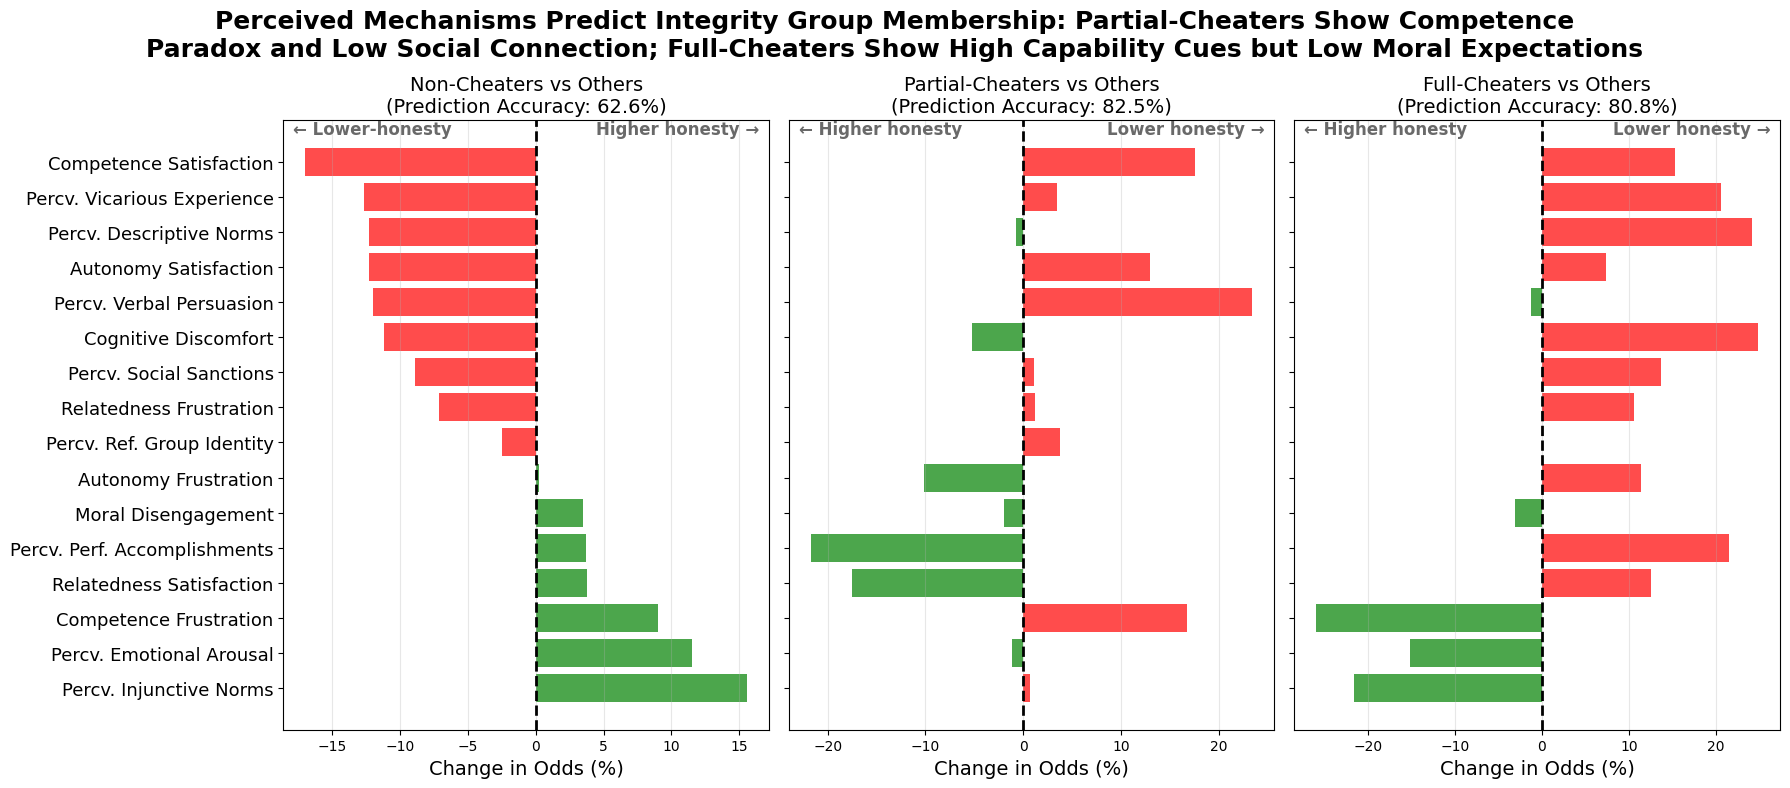


NON-CHEATERS VS OTHERS
Accuracy: 62.6% | N_target=734, N_others=425

                   Mechanism  Pct_Change  Odds_Ratio
     Percv. Injunctive Norms   15.566303    1.155663
    Percv. Emotional Arousal   11.493642    1.114936
      Competence Frustration    8.987277    1.089873
    Relatedness Satisfaction    3.788772    1.037888
Percv. Perf. Accomplishments    3.664147    1.036641
         Moral Disengagement    3.453663    1.034537
        Autonomy Frustration    0.253300    1.002533
  Percv. Ref. Group Identity   -2.502286    0.974977
     Relatedness Frustration   -7.150260    0.928497
     Percv. Social Sanctions   -8.875416    0.911246
        Cognitive Discomfort  -11.172929    0.888271
    Percv. Verbal Persuasion  -11.970231    0.880298
       Autonomy Satisfaction  -12.293129    0.877069
    Percv. Descriptive Norms  -12.299532    0.877005
 Percv. Vicarious Experience  -12.670541    0.873295
     Competence Satisfaction  -16.988967    0.830110

PARTIAL-CHEATERS VS OTHERS
A

In [ ]:
#==============================================================================
# Logistic Regressions: Mechanism Effects on Integrity Group Membership (All Three Comparisons)
#-==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Exclude perceived_ability from mechanisms
mechanisms_filtered = [m for m in mechanisms if m != 'perceived_ability']

# Prepare base data
X = df_int[mechanisms_filtered].dropna()

# Function to fit model and get results
def fit_logistic_model(target_group, group_label):
    y = df_int.loc[X.index, 'integrity_group'].apply(lambda x: 1 if x == target_group else 0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_scaled, y)
    
    results = pd.DataFrame({
        'Mechanism': [mechanism_display_names[m] for m in mechanisms_filtered],
        'Coefficient': model.coef_[0],
        'Odds_Ratio': np.exp(model.coef_[0])
    })
    results['Pct_Change'] = (results['Odds_Ratio'] - 1) * 100
    results['Group'] = group_label
    results['Accuracy'] = model.score(X_scaled, y)
    results['N_target'] = y.sum()
    results['N_others'] = len(y) - y.sum()
    
    return results

# Fit all three models
results_fc = fit_logistic_model('full_cheaters', 'Full-Cheaters vs Others')
results_pc = fit_logistic_model('partial_cheaters', 'Partial-Cheaters vs Others')
results_nc = fit_logistic_model('non_cheaters', 'Non-Cheaters vs Others')

# Sort by NON-CHEATERS effect (consistent order across all plots)
mechanism_order = results_nc.sort_values('Pct_Change', ascending=False)['Mechanism'].tolist()

# Reorder all dataframes to match
results_fc = results_fc.set_index('Mechanism').loc[mechanism_order].reset_index()
results_pc = results_pc.set_index('Mechanism').loc[mechanism_order].reset_index()
results_nc = results_nc.set_index('Mechanism').loc[mechanism_order].reset_index()

# Create 3-panel plot
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

for idx, (ax, results, title) in enumerate(zip(axes, 
                               [results_nc, results_pc, results_fc],
                               ['Non-Cheaters vs Others', 'Partial-Cheaters vs Others', 'Full-Cheaters vs Others'])):
    
    # Color logic: 
    # Non-cheaters: positive % = good (green), negative % = bad (red)
    # Partial/Full-cheaters: negative % = good (green), positive % = bad (red)
    if idx == 0:  # Non-cheaters: higher odds = more honesty
        colors = ['green' if x > 0 else 'red' for x in results['Pct_Change']]
        left_label, right_label = "← Lower-honesty", "Higher honesty →"
    else:  # Partial / Full cheaters: higher odds = more cheating
        colors = ['green' if x < 0 else 'red' for x in results['Pct_Change']]
        left_label, right_label = "← Higher honesty", "Lower honesty →"
    
    y_pos = np.arange(len(results))
    
    ax.barh(y_pos, results['Pct_Change'], color=colors, alpha=0.7)
    ax.axvline(0, color='black', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Change in Odds (%)', fontsize=14)
    # ax.set_title(f'{title}\n(Accuracy: {results["Accuracy"].iloc[0]:.1%}, N={results["N_target"].iloc[0]} vs {results["N_others"].iloc[0]})', 
    #              fontsize=14, fontweight='bold')
    ax.set_title(f'{title}\n(Prediction Accuracy: {results["Accuracy"].iloc[0]:.1%})', 
                 fontsize=14,)
    
    # Add value labels
    # for i, pct in enumerate(results['Pct_Change']):
    #     label = f'{pct:+.0f}%'
    #     ax.text(pct + (1 if pct > 0 else -1), i, label, 
    #             va='center', ha='left' if pct > 0 else 'right', fontsize=10)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0] + (xlim[1]-xlim[0])*0.02, ylim[1] - 0.5, left_label,
            ha='left', va='bottom', fontsize=12, color='dimgray', fontweight='bold')
    ax.text(xlim[1] - (xlim[1]-xlim[0])*0.02, ylim[1] - 0.5, right_label,
            ha='right', va='bottom', fontsize=12, color='dimgray', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

# Y-axis labels only on first plot - using the consistent mechanism order
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(mechanism_order, fontsize=13)

fig.suptitle('Perceived Mechanisms Predict Integrity Group Membership: Partial-Cheaters Show Competence\nParadox and Low Social Connection; Full-Cheaters Show High Capability Cues but Low Moral Expectations', 
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print summary tables
for results, title in [(results_nc, 'NON-CHEATERS'), (results_pc, 'PARTIAL-CHEATERS'), (results_fc, 'FULL-CHEATERS')]:
    print("\n" + "="*80)
    print(f"{title} VS OTHERS")
    print("="*80)
    print(f"Accuracy: {results['Accuracy'].iloc[0]:.1%} | N_target={results['N_target'].iloc[0]}, N_others={results['N_others'].iloc[0]}\n")
    print(results[['Mechanism', 'Pct_Change', 'Odds_Ratio']].to_string(index=False))

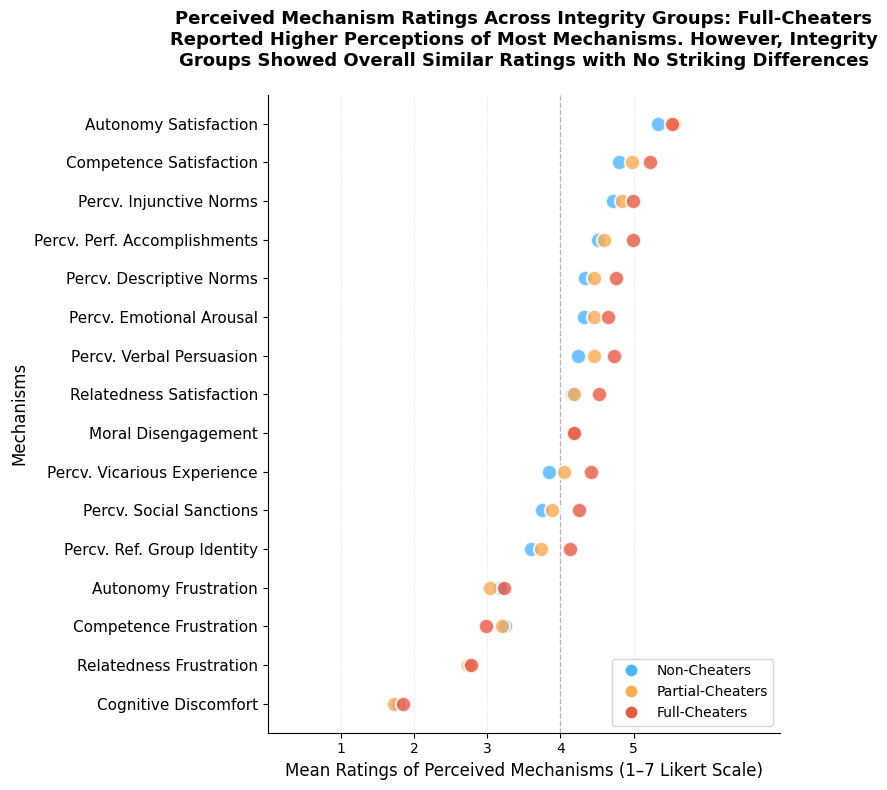

In [ ]:
#==============================================================================
# [Additional] RQ3 Plots: Lollipop Chart of Mechanism Means by Integrity Group
#==============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare data - exclude perceived_ability
mechanisms_filtered = [m for m in mechanisms if m != 'perceived_ability']

mechanism_means = []
for mech in mechanisms_filtered:
    for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
        mean_val = df_int[df_int['integrity_group'] == group][mech].mean()
        mechanism_means.append({
            'mechanism': mechanism_display_names[mech],
            'group': group.replace('_', '-').title(),
            'mean': mean_val
        })

plot_df = pd.DataFrame(mechanism_means)

# Sort mechanisms by overall mean (or keep your preferred order)
mechanisms_sorted = plot_df.groupby('mechanism')['mean'].mean().sort_values(ascending=True).index

# Create lollipop chart
fig, ax = plt.subplots(figsize=(8, 8))

colors = {
    'Non-Cheaters': '#4bb4ff', 
    'Partial-Cheaters': '#f9ac53', 
    'Full-Cheaters': '#e85943'
}

group_order = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
group_offsets = {'Non-Cheaters': 0, 'Partial-Cheaters': 0, 'Full-Cheaters': 0}

y_positions = []
y_labels = []

for y_pos, mech in enumerate(mechanisms_sorted):
    mech_data = plot_df[plot_df['mechanism'] == mech]
    
    # Draw all three groups on the same horizontal line with slight offsets
    for group in group_order:
        row = mech_data[mech_data['group'] == group]
        if not row.empty:
            mean_val = row['mean'].values[0]
            y_offset = y_pos + group_offsets[group]
            
            # Draw lollipop stick
            # ax.plot([0, mean_val], [y_offset, y_offset], 
                    # color=colors[group], linewidth=2, alpha=0.7)
            
            # Draw lollipop head
            ax.scatter(mean_val, y_offset, 
                      color=colors[group], s=120, zorder=3, 
                      edgecolors='white', linewidth=1.5, alpha=0.8)
    
    y_positions.append(y_pos)
    y_labels.append(mech)

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels, fontsize=11)
ax.set_xlabel('Mean Ratings of Perceived Mechanisms (1–7 Likert Scale)', fontsize=12)
ax.set_xlim(0, 7)
ax.set_xticks(range(1, 6))
ax.set_ylabel('Mechanisms', fontsize=12)

# Add vertical line at midpoint (4)
ax.axvline(x=4, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=colors[group], markersize=10,
                              label=group, markeredgecolor='white', markeredgewidth=1.5)
                   for group in group_order]
ax.legend(handles=legend_elements, 
          loc='lower right', frameon=True, fontsize=10)

# Title
ax.set_title('Perceived Mechanism Ratings Across Integrity Groups: Full-Cheaters\n'
             'Reported Higher Perceptions of Most Mechanisms. However, Integrity\n'
             'Groups Showed Overall Similar Ratings with No Striking Differences\n',
             fontsize=13, fontweight='bold')


# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

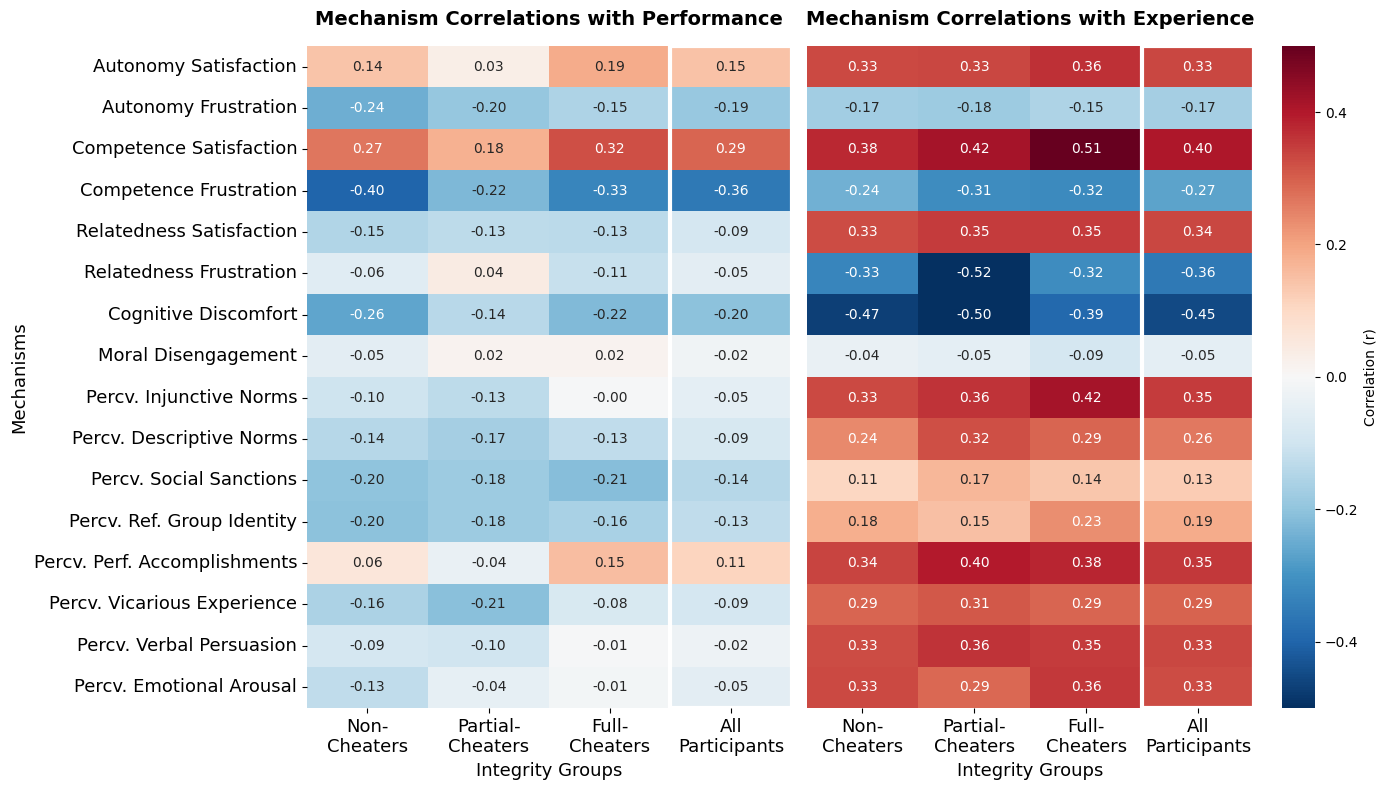

In [ ]:
#==============================================================================
# RQ3 Plots: Mechanism -> performance and experience
#==============================================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Define mechanism display names (excluding perceived_ability)
mechanism_display_names = {
    'autonomy_need_satisfaction': 'Autonomy Satisfaction',
    'autonomy_need_frustration': 'Autonomy Frustration',
    'competence_need_satisfaction': 'Competence Satisfaction',
    'competence_need_frustration': 'Competence Frustration',
    'relatedness_need_satisfaction': 'Relatedness Satisfaction',
    'relatedness_need_frustration': 'Relatedness Frustration',
    'cognitive_discomfort': 'Cognitive Discomfort',
    'moral_disengagement': 'Moral Disengagement',
    'injunctive_norms': 'Percv. Injunctive Norms',
    'descriptive_norms': 'Percv. Descriptive Norms',
    'social_sanctions': 'Percv. Social Sanctions',
    'reference_group_identification': 'Percv. Ref. Group Identity',
    'performance_accomplishments': 'Percv. Perf. Accomplishments',
    'vicarious_experience': 'Percv. Vicarious Experience',
    'verbal_persuasion': 'Percv. Verbal Persuasion',
    'emotional_arousal': 'Percv. Emotional Arousal',
}

# Remove perceived_ability from mechanisms list
mechanisms_for_plot = [m for m in mechanisms if m != 'perceived_ability']

# Create two separate plots side by side with adjusted width ratios
fig, axes = plt.subplots(1, 2, figsize=(14, 8), width_ratios=[1.3, 1.5])
integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
group_labels = ['Non-\nCheaters', 'Partial-\nCheaters', 'Full-\nCheaters', 'All\nParticipants']
outcomes = ['performance', 'experience']
outcome_titles = ['Performance', 'Experience']

for outcome_idx, (outcome, outcome_title) in enumerate(zip(outcomes, outcome_titles)):
    # Prepare correlation matrix for all three groups + combined
    corr_matrix = []
    
    # Individual groups
    for group in integrity_groups:
        group_data = df_int[df_int['integrity_group'] == group]
        correlations = [group_data[mechanism].corr(group_data[outcome]) 
                       for mechanism in mechanisms_for_plot]
        corr_matrix.append(correlations)
    
    # All participants combined
    all_correlations = [df_int[mechanism].corr(df_int[outcome]) 
                       for mechanism in mechanisms_for_plot]
    corr_matrix.append(all_correlations)
    
    corr_matrix = np.array(corr_matrix).T  # Transpose to have mechanisms as rows
    
    # Get display names for y-axis
    y_labels = [mechanism_display_names[m] for m in mechanisms_for_plot]
    
    # Plot heatmap
    sns.heatmap(corr_matrix,
                annot=True,
                fmt='.2f',
                cmap='RdBu_r',
                center=0,
                vmin=-0.5, vmax=0.5,
                xticklabels=group_labels,
                yticklabels=y_labels if outcome_idx == 0 else [],
                ax=axes[outcome_idx],
                cbar=outcome_idx == 1,
                cbar_kws={'label': 'Correlation (r)'} if outcome_idx == 1 else None)
    
    # Highlight "All" column (last column)
    num_rows = corr_matrix.shape[0]
    num_cols = corr_matrix.shape[1]
    
    # Rectangle coordinates: x, y in data coordinates
    rect = patches.Rectangle(
        (num_cols-1, 0),  # bottom-left corner of rectangle (last column)
        1,                 # width (1 column)
        num_rows,          # height (all rows)
        fill=False,
        edgecolor='white',
        linewidth=3
    )
    axes[outcome_idx].add_patch(rect)
    
    axes[outcome_idx].set_title(f'Mechanism Correlations with {outcome_title}', 
                                fontsize=14, fontweight='bold', pad=15)
    axes[outcome_idx].set_xlabel('Integrity Groups', fontsize=13)
    if outcome_idx == 0:
        axes[outcome_idx].set_ylabel('Mechanisms', fontsize=13)
    axes[outcome_idx].tick_params(axis='x', labelsize=13)  # x-axis tick labels
    axes[outcome_idx].tick_params(axis='y', labelsize=13)  # y-axis tick labels

plt.tight_layout()
plt.show()

#### Additional exploration:
#### **Are performance and experience correlated differently across integrity groups?** - YES; correlation for full-cheaters is highest
#### **Is correlations between performance and experience modulated by perceived mechanisms?** - SOMEWHAT; only 2 mechanisms

In [274]:
# =============================================================================
# Performance-Experience Correlations across Integrity Groups
# =============================================================================

print("\n" + "="*80)
print("PERFORMANCE-EXPERIENCE CORRELATIONS ACROSS INTEGRITY GROUPS")
print("="*80)

from scipy.stats import pearsonr
import pandas as pd

df_int = df_combined

correlation_summary = []
correlations = {}

for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group]
    
    # Performance–Experience correlation
    perf_exp = group_data[['performance', 'experience']].dropna()
    if len(perf_exp) > 2:
        r_perf, p_perf = pearsonr(perf_exp['performance'], perf_exp['experience'])
        n_perf = len(perf_exp)
    else:
        r_perf, p_perf = (np.nan, np.nan)
        n_perf = 0
    
    # Perceived Ability–Performance correlation
    pa_perf = group_data[['perceived_ability', 'performance']].dropna()
    if len(pa_perf) > 2:
        r_pa, p_pa = pearsonr(pa_perf['perceived_ability'], pa_perf['performance'])
        n_pa = len(pa_perf)
    else:
        r_pa, p_pa = (np.nan, np.nan)
        n_pa = 0
    
    correlations[group] = {'r': r_perf, 'p': p_perf, 'n': n_perf}
    
    correlation_summary.append({
        'Integrity Group': group.replace('_', '-').title(),
        'r (Perf-Exp)': f"{r_perf:.3f}",
        'p': f"{p_perf:.4f}",
        'Sig': '***' if p_perf < 0.001 else '**' if p_perf < 0.01 else '*' if p_perf < 0.05 else 'ns',
        'r (PA-Perf)': f"{r_pa:.3f}",
        'p.1': f"{p_pa:.4f}",
        'Sig.1': '***' if p_pa < 0.001 else '**' if p_pa < 0.01 else '*' if p_pa < 0.05 else 'ns'
    })

corr_df = pd.DataFrame(correlation_summary)
print("\n" + corr_df.to_string(index=False))

# Fisher's Z-tests for comparing correlations
print("\n" + "-"*80)
print("Fisher's Z-tests (comparing Perf-Exp correlations between groups):")
print("-"*80)

def fishers_z_test(r1, n1, r2, n2):
    """Compare two correlation coefficients using Fisher's Z transformation"""
    z1 = 0.5 * np.log((1 + r1) / (1 - r1))
    z2 = 0.5 * np.log((1 + r2) / (1 - r2))
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    z_stat = (z1 - z2) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    return z_stat, p_value

comparisons = [
    ('non_cheaters', 'partial_cheaters'),
    ('non_cheaters', 'full_cheaters'),
    ('partial_cheaters', 'full_cheaters')
]

for g1, g2 in comparisons:
    z_stat, p_val = fishers_z_test(
        correlations[g1]['r'], correlations[g1]['n'],
        correlations[g2]['r'], correlations[g2]['n']
    )
    print(f"\n{g1.replace('_', '-').title()} vs {g2.replace('_', '-').title()}:")
    print(f"  Z = {z_stat:.3f}, p = {p_val:.4f}, {'***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'}")

print("="*80)

print(f"\nImportant findings")
print(f"    Non-cheaters: significant but weak positive correlations between performance and experience (r=0.12, p<.001)")
print(f"    Full-cheaters: significant and small to moderate positive correlations between performance and experience (r=0.22, p<.001)")
print(f"    Partial-cheaters: no significant correlation between performance and experience")


PERFORMANCE-EXPERIENCE CORRELATIONS ACROSS INTEGRITY GROUPS

 Integrity Group r (Perf-Exp)      p Sig r (PA-Perf)    p.1 Sig.1
    Non-Cheaters        0.120 0.0000 ***       0.141 0.0000   ***
Partial-Cheaters       -0.009 0.8584  ns      -0.118 0.0160     *
   Full-Cheaters        0.219 0.0000 ***       0.065 0.1632    ns

--------------------------------------------------------------------------------
Fisher's Z-tests (comparing Perf-Exp correlations between groups):
--------------------------------------------------------------------------------

Non-Cheaters vs Partial-Cheaters:
  Z = 2.334, p = 0.0196, *

Non-Cheaters vs Full-Cheaters:
  Z = -1.923, p = 0.0544, ns

Partial-Cheaters vs Full-Cheaters:
  Z = -3.427, p = 0.0006, ***

Important findings
    Non-cheaters: significant but weak positive correlations between performance and experience (r=0.12, p<.001)
    Full-cheaters: significant and small to moderate positive correlations between performance and experience (r=0.22, p<.

In [ ]:
# =============================================================================
# Mechanism Modulation Analysis: Median-Split with Fisher's Z-Test
# =============================================================================

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import stats

print("\n" + "="*80)
print("MECHANISM MODULATION OF PERFORMANCE-EXPERIENCE RELATIONSHIP")
print("Enhanced Median-Split Approach with Statistical Significance Testing")
print("="*80)

# Filter to intervention participants only
df_int = df[df['condition'] != 'control'].copy()

# Define mechanisms
mechanisms = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'performance_accomplishments', 'vicarious_experience',
    'verbal_persuasion', 'emotional_arousal',
    'injunctive_norms', 'descriptive_norms',
    'reference_group_identification', 'social_sanctions',
    'cognitive_discomfort', 'moral_disengagement'
]

# Fisher's Z-test function for comparing two correlations
def compare_correlations(r1, n1, r2, n2):
    """
    Compare two independent correlation coefficients using Fisher's Z-transformation.
    
    Returns:
        z_stat: Z-statistic
        p_value: Two-tailed p-value
        diff: Difference in correlations (r1 - r2)
    """
    # Fisher Z-transformation
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    
    # Standard error of the difference
    se_diff = np.sqrt(1/(n1-3) + 1/(n2-3))
    
    # Z-statistic
    z_stat = (z1 - z2) / se_diff
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    diff = r1 - r2
    
    return z_stat, p_value, diff

# Storage for results
results = []

# Analyze for each integrity group
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']:
    print(f"\n{'='*80}")
    print(f"GROUP: {group.replace('_', ' ').upper()}")
    print(f"{'='*80}")
    
    if group == 'all':
        group_data = df_int.copy()
    else:
        group_data = df_int[df_int['integrity_group'] == group].copy()
    
    print(f"Total N: {len(group_data)}")
    
    # For each mechanism
    for mech in mechanisms:
        # Get clean data
        clean_data = group_data[[mech, 'performance', 'experience']].dropna()
        
        if len(clean_data) < 40:  # Need sufficient sample size
            continue
        
        # Median split
        median_val = clean_data[mech].median()
        high_mech = clean_data[clean_data[mech] >= median_val]
        low_mech = clean_data[clean_data[mech] < median_val]
        
        n_high = len(high_mech)
        n_low = len(low_mech)
        
        # Skip if groups too small
        if n_high < 20 or n_low < 20:
            continue
        
        # Compute correlations for each group
        r_high, p_high = pearsonr(high_mech['performance'], high_mech['experience'])
        r_low, p_low = pearsonr(low_mech['performance'], low_mech['experience'])
        
        # Fisher's Z-test to compare correlations
        z_stat, p_diff, diff = compare_correlations(r_high, n_high, r_low, n_low)
        
        # Determine significance
        if p_diff < 0.001:
            sig = '***'
        elif p_diff < 0.01:
            sig = '**'
        elif p_diff < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        
        # Store results
        results.append({
            'Integrity_Group': group.replace('_', '-').title(),
            'Mechanism': mech,
            'r_high': r_high,
            'p_high': p_high,
            'n_high': n_high,
            'r_low': r_low,
            'p_low': p_low,
            'n_low': n_low,
            'r_diff': diff,
            'z_stat': z_stat,
            'p_diff': p_diff,
            'Sig': sig
        })

# Create results dataframe
results_df = pd.DataFrame(results)

# Sort by absolute difference for each group
results_df['abs_diff'] = results_df['r_diff'].abs()
results_df = results_df.sort_values(['Integrity_Group', 'abs_diff'], ascending=[True, False])

# Display results
print("\n" + "="*80)
print("SUMMARY: TOP MECHANISMS SHOWING MODULATION EFFECTS")
print("="*80)
print("\nLegend:")
print("  r_high: Correlation for high mechanism group")
print("  r_low: Correlation for low mechanism group")
print("  r_diff: Difference (high - low)")
print("  z_stat: Fisher's Z-statistic")
print("  p_diff: p-value for difference test")
print("  Sig: *p<.05, **p<.01, ***p<.001, ns=not significant")

for grp in results_df['Integrity_Group'].unique():
    print(f"\n{'='*80}")
    print(f"{grp}")
    print(f"{'='*80}")
    
    group_results = results_df[results_df['Integrity_Group'] == grp].head(10)
    
    display_cols = ['Mechanism', 'r_high', 'r_low', 'r_diff', 'z_stat', 'p_diff', 'Sig']
    print(group_results[display_cols].to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# Export significant results
print("\n" + "="*80)
print("SIGNIFICANT MODULATION EFFECTS (p < .05)")
print("="*80)

sig_results = results_df[results_df['p_diff'] < 0.05].copy()
sig_results = sig_results.sort_values(['Integrity_Group', 'p_diff'])

if len(sig_results) > 0:
    display_cols = ['Integrity_Group', 'Mechanism', 'r_high', 'r_low', 'r_diff', 'p_diff', 'Sig', 'n_high', 'n_low']
    print(sig_results[display_cols].to_string(index=False, float_format=lambda x: f"{x:.3f}"))
else:
    print("No significant modulation effects found at p < .05")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
for grp in results_df['Integrity_Group'].unique():
    grp_data = results_df[results_df['Integrity_Group'] == grp]
    n_sig = len(grp_data[grp_data['p_diff'] < 0.05])
    n_total = len(grp_data)
    print(f"\n{grp}:")
    print(f"  Significant modulation effects: {n_sig}/{n_total} ({100*n_sig/n_total:.1f}%)")
    print(f"  Mean |r_diff|: {grp_data['abs_diff'].mean():.3f}")
    print(f"  Max |r_diff|: {grp_data['abs_diff'].max():.3f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


MECHANISM MODULATION OF PERFORMANCE-EXPERIENCE RELATIONSHIP
Enhanced Median-Split Approach with Statistical Significance Testing

GROUP: NON CHEATERS
Total N: 734

GROUP: PARTIAL CHEATERS
Total N: 203

GROUP: FULL CHEATERS
Total N: 222

GROUP: ALL
Total N: 1159

SUMMARY: TOP MECHANISMS SHOWING MODULATION EFFECTS

Legend:
  r_high: Correlation for high mechanism group
  r_low: Correlation for low mechanism group
  r_diff: Difference (high - low)
  z_stat: Fisher's Z-statistic
  p_diff: p-value for difference test
  Sig: *p<.05, **p<.01, ***p<.001, ns=not significant

All
                     Mechanism  r_high  r_low  r_diff  z_stat  p_diff Sig
 relatedness_need_satisfaction   0.101  0.225  -0.124  -2.080   0.038   *
           moral_disengagement   0.075  0.166  -0.092  -1.579   0.114  ns
  competence_need_satisfaction   0.067  0.015   0.052   0.872   0.383  ns
             verbal_persuasion   0.104  0.153  -0.048  -0.833   0.405  ns
    autonomy_need_satisfaction   0.081  0.123  -0.04


VISUALIZING MECHANISM MODULATION EFFECTS


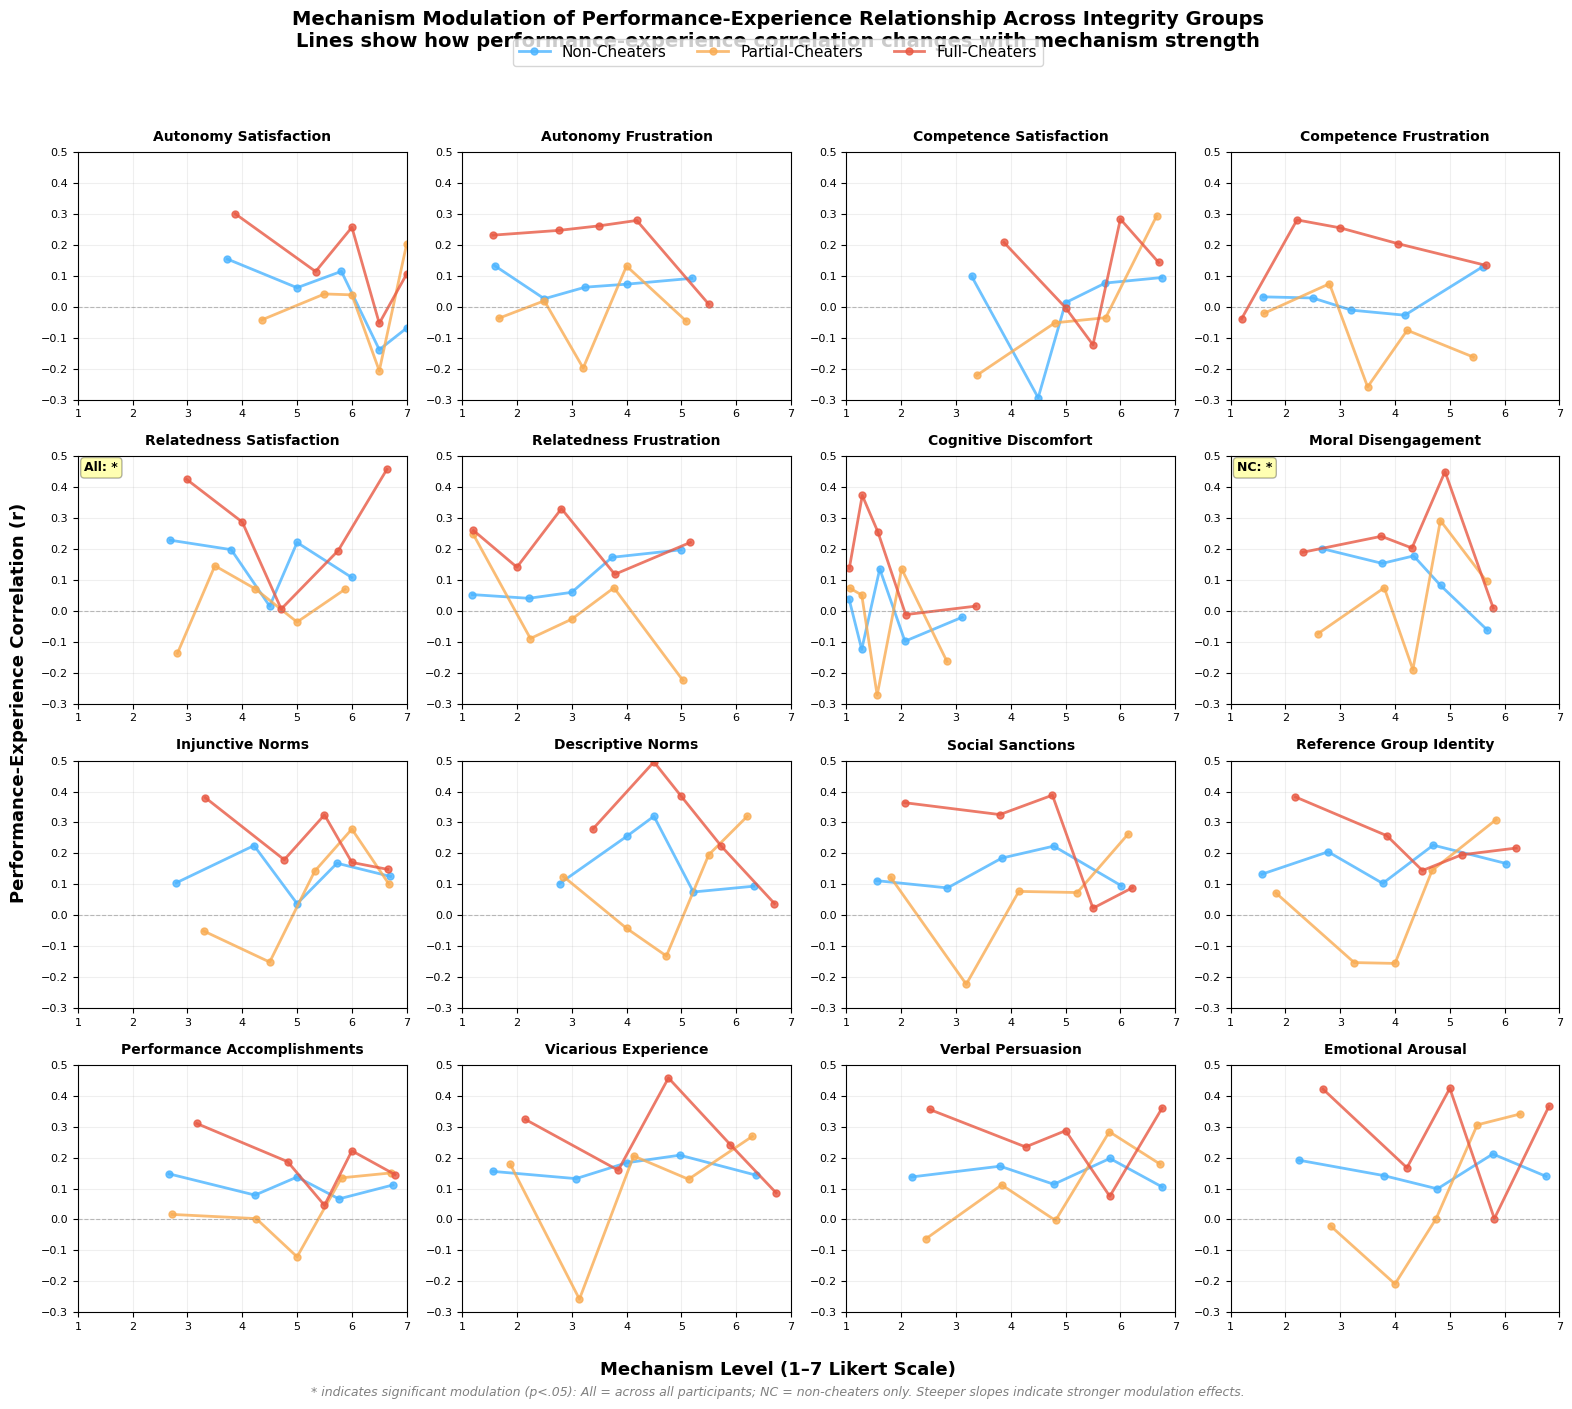


Plot saved as 'mechanism_modulation_plots.png'


In [ ]:
# =============================================================================
# Visualization: Mechanism Modulation of Performance-Experience Relationship
# 2D Line Plots (4x4 Grid) - Median Split Approach
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

print("\n" + "="*80)
print("VISUALIZING MECHANISM MODULATION EFFECTS")
print("="*80)

# Reuse existing mechanism list and display names
mechanisms_plot = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'injunctive_norms', 'descriptive_norms',
    'social_sanctions', 'reference_group_identification',
    'performance_accomplishments', 'vicarious_experience',
    'verbal_persuasion', 'emotional_arousal'
]

mechanism_labels = {
    'autonomy_need_satisfaction': 'Autonomy Satisfaction',
    'autonomy_need_frustration': 'Autonomy Frustration',
    'competence_need_satisfaction': 'Competence Satisfaction',
    'competence_need_frustration': 'Competence Frustration',
    'relatedness_need_satisfaction': 'Relatedness Satisfaction',
    'relatedness_need_frustration': 'Relatedness Frustration',
    'cognitive_discomfort': 'Cognitive Discomfort',
    'moral_disengagement': 'Moral Disengagement',
    'injunctive_norms': 'Injunctive Norms',
    'descriptive_norms': 'Descriptive Norms',
    'social_sanctions': 'Social Sanctions',
    'reference_group_identification': 'Reference Group Identity',
    'performance_accomplishments': 'Performance Accomplishments',
    'vicarious_experience': 'Vicarious Experience',
    'verbal_persuasion': 'Verbal Persuasion',
    'emotional_arousal': 'Emotional Arousal'
}

# Group colors (reuse from earlier)
colors = {
    'non_cheaters': '#4bb4ff',
    'partial_cheaters': '#f9ac53',
    'full_cheaters': '#e85943'
}

# Filter intervention data
df_int = df_combined[df_combined['condition'] == 'intervention'].copy()

# Calculate correlations across mechanism range
def calc_correlation_by_level(data, mechanism, perf_var='performance', exp_var='experience'):
    """Calculate performance-experience correlation at different mechanism levels"""
    # Get valid data
    valid = data[[mechanism, perf_var, exp_var]].dropna()
    if len(valid) < 30:
        return None, None
    
    # Create bins for mechanism levels (tertiles for smoothness)
    valid['mech_bin'] = pd.qcut(valid[mechanism], q=5, labels=False, duplicates='drop')
    
    mech_levels = []
    correlations = []
    
    for bin_val in sorted(valid['mech_bin'].unique()):
        bin_data = valid[valid['mech_bin'] == bin_val]
        if len(bin_data) >= 10:
            r, p = pearsonr(bin_data[perf_var], bin_data[exp_var])
            mech_level = bin_data[mechanism].mean()
            mech_levels.append(mech_level)
            correlations.append(r)
    
    return mech_levels, correlations

# Create 4x4 grid plot
fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.flatten()

for idx, mechanism in enumerate(mechanisms_plot):
    ax = axes[idx]
    
    # Plot for each integrity group
    for group_name in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
        group_data = df_int[df_int['integrity_group'] == group_name]
        
        mech_levels, corrs = calc_correlation_by_level(group_data, mechanism)
        
        if mech_levels is not None and len(mech_levels) > 0:
            label = group_name.replace('_', '-').title()
            ax.plot(mech_levels, corrs, 'o-', color=colors[group_name], 
                   linewidth=2, markersize=5, alpha=0.8, label=label)
    
    # Formatting
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title(mechanism_labels[mechanism], fontsize=10, fontweight='bold', pad=8)
    ax.set_ylim(-0.3, 0.5)
    ax.set_xlim(1, 7)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.2)
    
    # Add significance markers for significant effects
    # (Based on earlier Fisher's Z results)
    if mechanism == 'relatedness_need_satisfaction':
        ax.text(0.02, 0.98, 'All: *', transform=ax.transAxes, 
               fontsize=9, fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
    elif mechanism == 'moral_disengagement':
        ax.text(0.02, 0.98, 'NC: *', transform=ax.transAxes,
               fontsize=9, fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Remove empty subplots (none in this case since we have exactly 16)

# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, 
          bbox_to_anchor=(0.5, 0.98), frameon=True, fontsize=11)

# Add common axis labels
fig.text(0.5, 0.02, 'Mechanism Level (1–7 Likert Scale)', 
        ha='center', fontsize=13, fontweight='bold')
fig.text(0.02, 0.5, 'Performance-Experience Correlation (r)', 
        va='center', rotation='vertical', fontsize=13, fontweight='bold')

# Add title
fig.suptitle(
    'Mechanism Modulation of Performance-Experience Relationship Across Integrity Groups\n'
    'Lines show how performance-experience correlation changes with mechanism strength',
    fontsize=14, fontweight='bold', y=0.995
)

# Add note at bottom
fig.text(0.5, 0.005,
        "* indicates significant modulation (p<.05): All = across all participants; NC = non-cheaters only. "
        "Steeper slopes indicate stronger modulation effects.",
        ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout(rect=[0.03, 0.04, 1, 0.96])
plt.savefig('mechanism_modulation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*80)